## Assignment¶
In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

Load the housing prices data from Thinkful's database.
Split your data into train and test sets.
Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
Is the performance of your model satisfactory? Why?
Try to improve your model in terms of predictive performance by adding or removing some variables.

In [1]:
## Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
#Data https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [2]:
#Loading the dataset
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(postgres_user, postgres_pw, postgres_host, 
                                                            postgres_port, postgres_db))
houseprices_df = pd.read_sql('select * from houseprices', con = engine)

## Data Exploration

In [3]:
print(houseprices_df.head())
engine.dispose()

   id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  landcontour utilities  ... poolarea poolqc fence miscfeature miscval mosold  \
0         Lvl    AllPub  ...        0   None  None        None       0      2   
1         Lvl    AllPub  ...        0   None  None        None       0      5   
2         Lvl    AllPub  ...        0   None  None        None       0      9   
3         Lvl    AllPub  ...        0   None  None        None       0      2   
4         Lvl    AllPub  ...        0   None  None        None       0     12   

  yrsold  saletype  salecondition  saleprice  
0   2008        WD   

In [4]:
## Finding highly correlated variables
house_corr = np.abs(houseprices_df.iloc[:, 1:].corr().loc[:, 'saleprice']).sort_values(ascending = False)
house_corr

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

In [5]:
## Looking for missing values
missing_values = (houseprices_df.isnull().sum()*100/houseprices_df.isnull().count()).sort_values(ascending = False)
missing_values.head(20)

poolqc          99.520548
miscfeature     96.301370
alley           93.767123
fence           80.753425
fireplacequ     47.260274
lotfrontage     17.739726
garagecond       5.547945
garagetype       5.547945
garageyrblt      5.547945
garagefinish     5.547945
garagequal       5.547945
bsmtexposure     2.602740
bsmtfintype2     2.602740
bsmtfintype1     2.534247
bsmtcond         2.534247
bsmtqual         2.534247
masvnrarea       0.547945
masvnrtype       0.547945
electrical       0.068493
utilities        0.000000
dtype: float64

In [6]:
houseprices_df1 = houseprices_df.copy()

In [7]:
## Dropping variabels with more than 45% of missing values
houseprices_df.drop(['poolqc', 'miscfeature'], axis =1, inplace = True)

In [8]:
houseprices_df.drop(['alley', 'fence', 'fireplacequ'], axis = 1, inplace = True)

In [9]:
missing_new = (houseprices_df.isnull().sum()*100/houseprices_df.isnull().count()).sort_values(ascending = False)
missing_new.head(20)

lotfrontage     17.739726
garagefinish     5.547945
garagetype       5.547945
garagecond       5.547945
garagequal       5.547945
garageyrblt      5.547945
bsmtexposure     2.602740
bsmtfintype2     2.602740
bsmtfintype1     2.534247
bsmtcond         2.534247
bsmtqual         2.534247
masvnrtype       0.547945
masvnrarea       0.547945
electrical       0.068493
roofstyle        0.000000
roofmatl         0.000000
saleprice        0.000000
exterior1st      0.000000
exterior2nd      0.000000
yearbuilt        0.000000
dtype: float64

In [10]:
## Dividing the dataset into numeric and nonnumeric columns
numeric_columns = houseprices_df.select_dtypes(['float', 'integer']).columns
non_numeric_columns = houseprices_df.select_dtypes(['object']).columns

In [11]:
print(len(numeric_columns))
print(len(non_numeric_columns))

38
38


In [12]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non

In [13]:
houseprices_df['neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [14]:
house_corr.head(10)

saleprice       1.000000
overallqual     0.790982
grlivarea       0.708624
garagecars      0.640409
garagearea      0.623431
totalbsmtsf     0.613581
firstflrsf      0.605852
fullbath        0.560664
totrmsabvgrd    0.533723
yearbuilt       0.522897
Name: saleprice, dtype: float64

In [15]:
## Looking for Outliers in variables with highcorrelation
col_list = ['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath', 
            'totrmsabvgrd', 'saleprice']

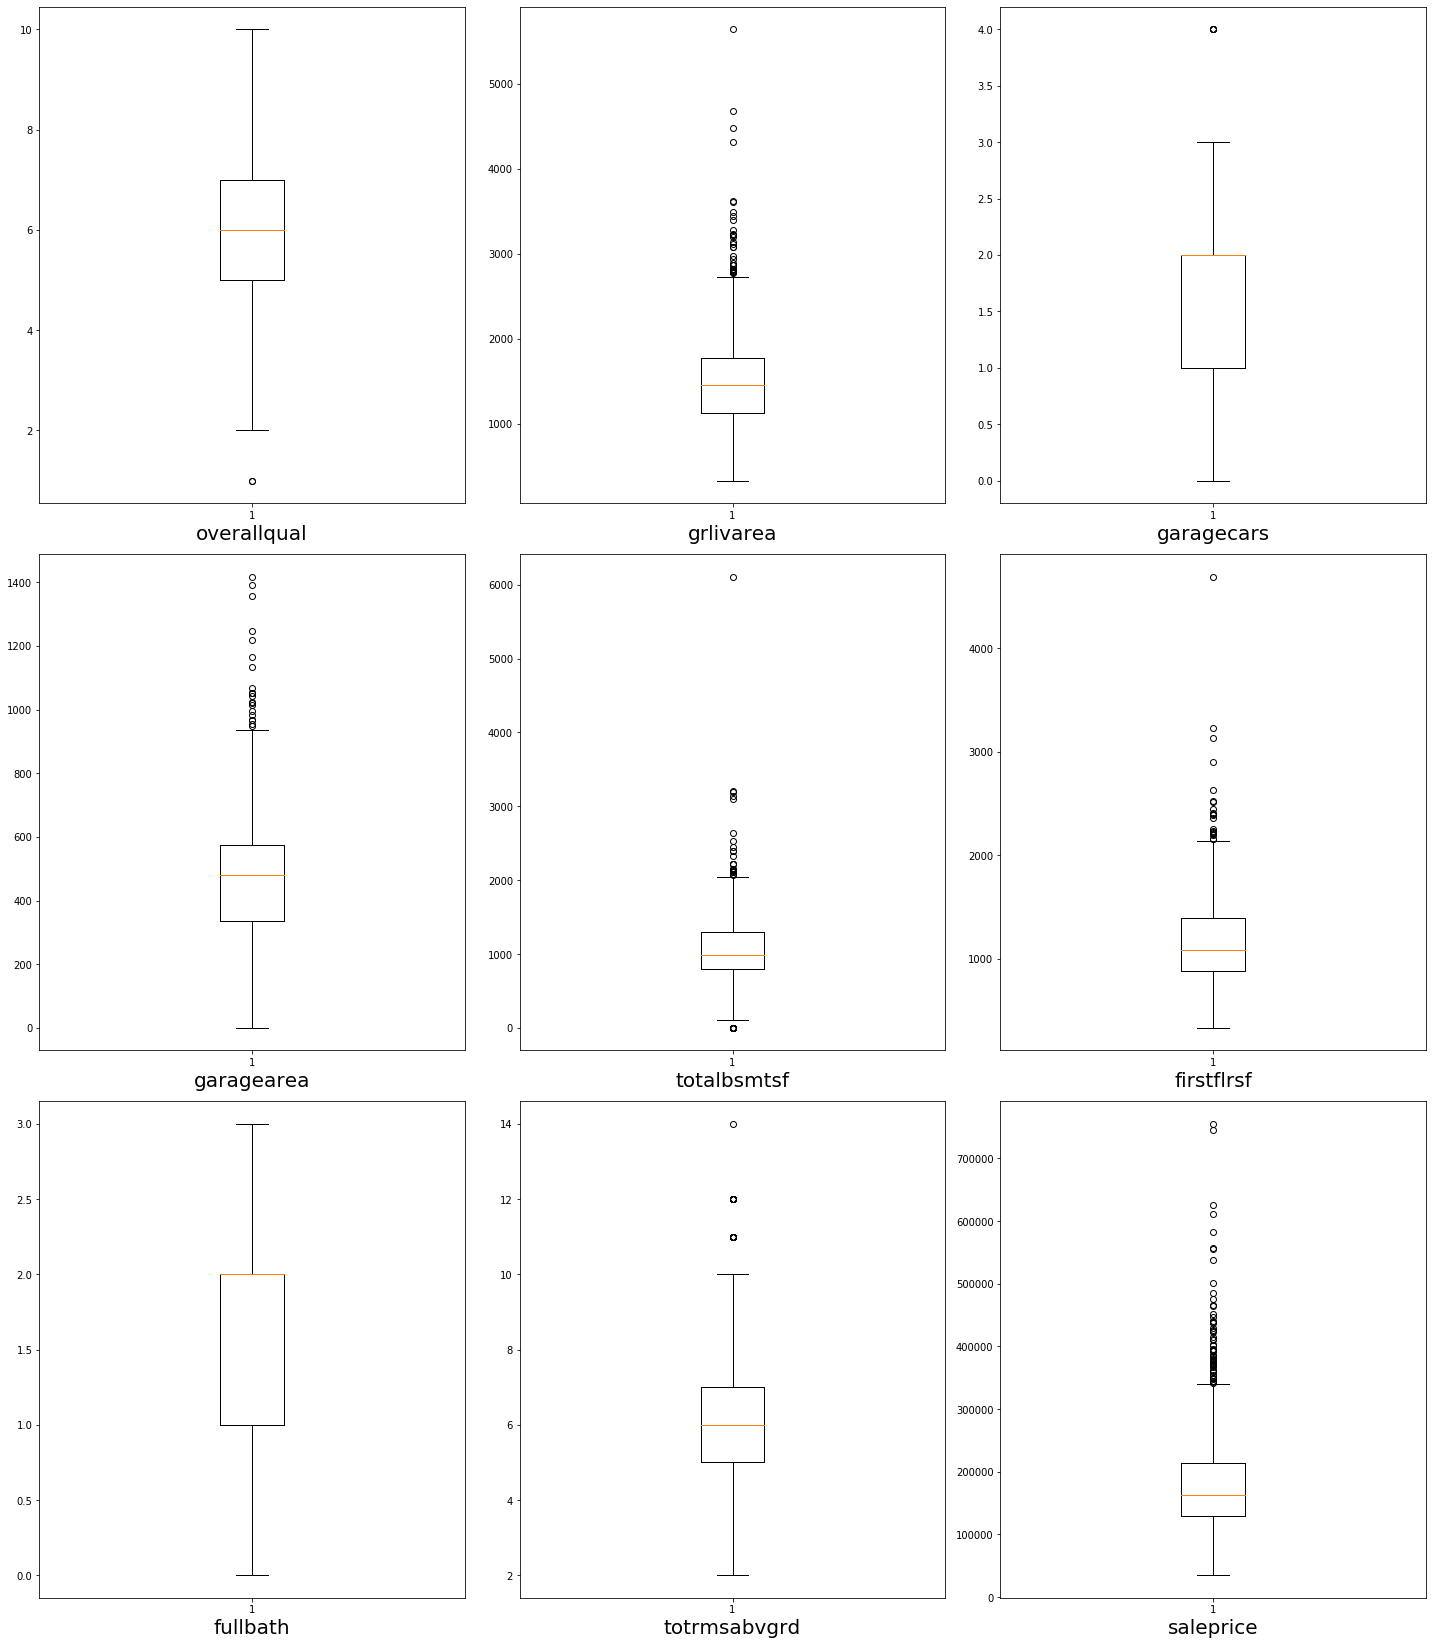

In [16]:
plt.figure(figsize = (20,30))
for index, col in enumerate(col_list):
    plt.subplot(4,3, index+1)
    plt.boxplot(houseprices_df[col])
    plt.xlabel(col, fontsize = 20)
plt.tight_layout()
    

In [17]:
houseprices_df['totalsf'] = houseprices_df['totalbsmtsf'] + houseprices_df['firstflrsf'] + houseprices_df['secondflrsf']

In [18]:
houseprices_df[['totalsf', 'saleprice']].corr()

,totalsf,saleprice
totalsf,1.00000,0.78226
saleprice,0.78226,1.00000


{'whiskers': [<matplotlib.lines.Line2D at 0x1c25ec3710>,
 'caps': [<matplotlib.lines.Line2D at 0x1c254f3470>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c25468518>],
 'medians': [<matplotlib.lines.Line2D at 0x1c25ecc400>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c25ecc748>],
 'means': []}

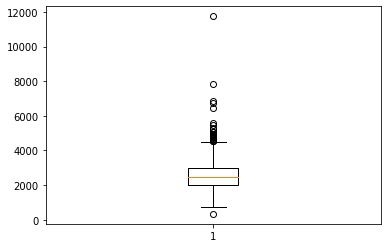

In [19]:
plt.boxplot(houseprices_df['totalsf'])

In [20]:
log_totalsf = np.log(houseprices_df['totalsf'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c25fad9e8>,
 'caps': [<matplotlib.lines.Line2D at 0x1c25fade80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c25fad5c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c25fba7b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c25fbab00>],
 'means': []}

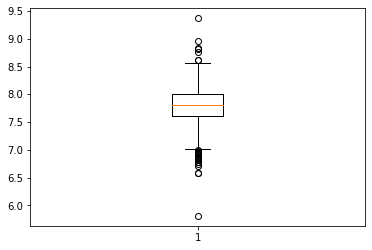

In [21]:
plt.boxplot(log_totalsf)

(array([  1.,   0.,  10.,  40., 299., 629., 418.,  58.,   4.,   1.]),
 array([5.81114099, 6.16720477, 6.52326854, 6.87933231, 7.23539608,
        7.59145986, 7.94752363, 8.3035874 , 8.65965117, 9.01571495,
        9.37177872]),
 <a list of 10 Patch objects>)

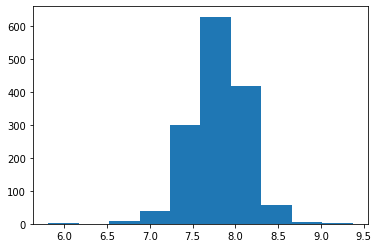

In [22]:
plt.hist(log_totalsf)

(array([ 62., 778., 521.,  86.,   8.,   3.,   1.,   0.,   0.,   1.]),
 array([  334. ,  1475.8,  2617.6,  3759.4,  4901.2,  6043. ,  7184.8,
         8326.6,  9468.4, 10610.2, 11752. ]),
 <a list of 10 Patch objects>)

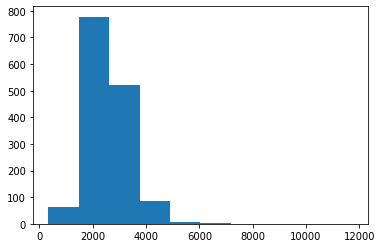

In [23]:
## The plot above is close to normal distribution than the plot below
plt.hist(houseprices_df['totalsf'])

In [24]:
log_saleprice = np.log(houseprices_df['saleprice'])

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

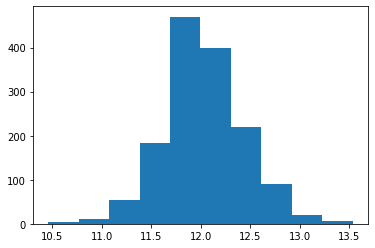

In [25]:
plt.hist(log_saleprice)

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

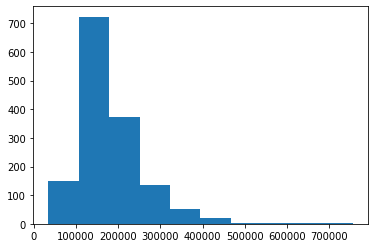

In [26]:
plt.hist(houseprices_df['saleprice'])

In [27]:
houseprices_df['log_saleprice'] = np.log(houseprices_df['saleprice'])

In [28]:
houseprices_df['log_totalsf'] = np.log(houseprices_df['totalsf'])

(array([107., 554., 535., 189.,  57.,  12.,   2.,   2.,   1.,   1.]),
 array([ 334. ,  864.8, 1395.6, 1926.4, 2457.2, 2988. , 3518.8, 4049.6,
        4580.4, 5111.2, 5642. ]),
 <a list of 10 Patch objects>)

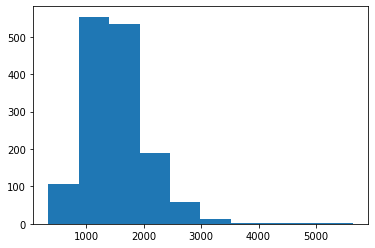

In [29]:
plt.hist(houseprices_df['grlivarea'])

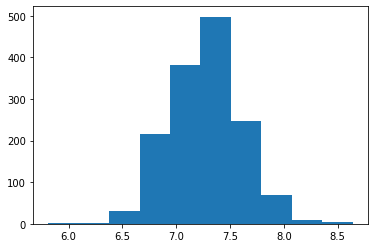

In [30]:
log_grlivarea = np.log(houseprices_df['grlivarea'])
plt.hist(log_grlivarea)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c24424128>,
 'caps': [<matplotlib.lines.Line2D at 0x1c244240b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c24424e10>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2647e128>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2647ea90>],
 'means': []}

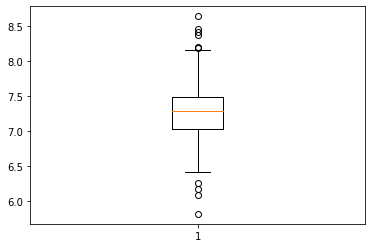

In [31]:
plt.boxplot(log_grlivarea)


In [32]:
numeric_data = houseprices_df.select_dtypes(['float', 'integer'])
numeric_data.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,totalsf,log_saleprice,log_totalsf
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,2,2008,208500,2566,12.247694,7.850104
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,5,2007,181500,2524,12.109011,7.833600
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,9,2008,223500,2706,12.317167,7.903227
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,2,2006,140000,2473,11.849398,7.813187
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,12,2008,250000,3343,12.429216,8.114624


In [33]:
col_list

['overallqual',
 'grlivarea',
 'garagecars',
 'garagearea',
 'totalbsmtsf',
 'firstflrsf',
 'fullbath',
 'totrmsabvgrd',
 'saleprice']

In [34]:
High_corr = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'totalsf', 'log_totalsf',
                           'fullbath', 'totrmsabvgrd', 'saleprice', 'log_saleprice']]
High_corr1 = High_corr.corr()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text yticklabel objects>)

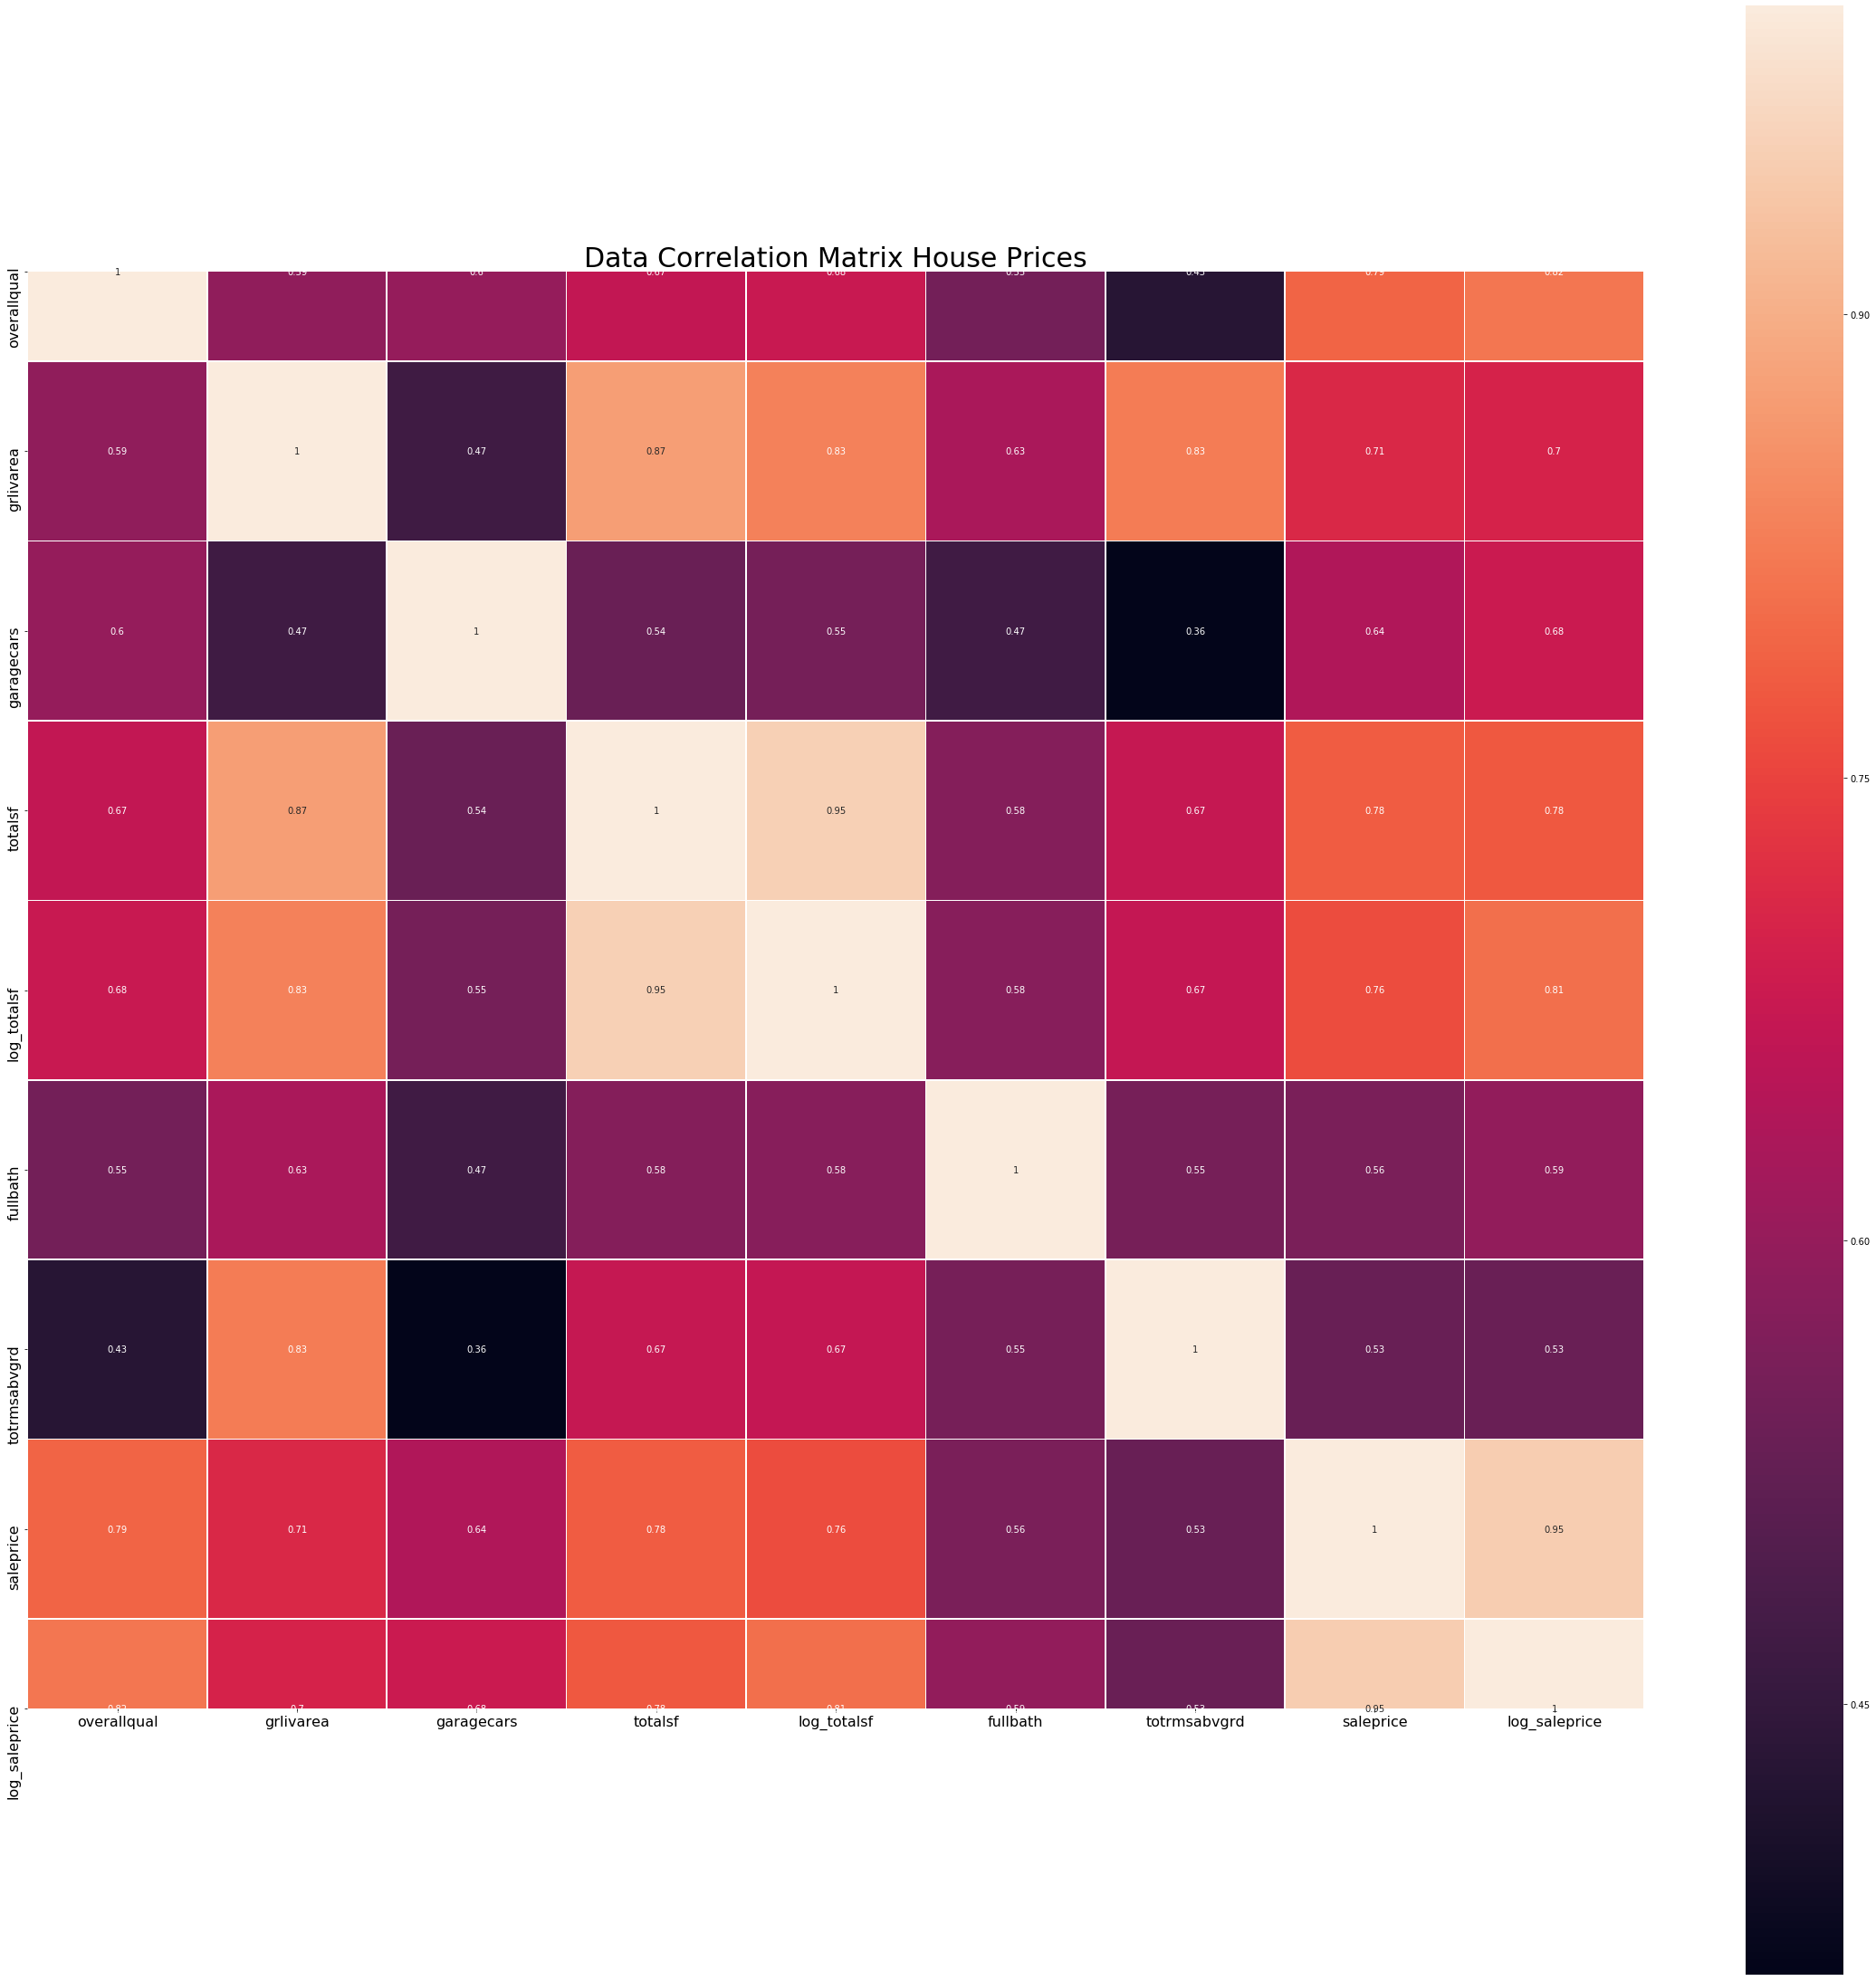

In [35]:
plt.figure(figsize = (40,40))
sns.heatmap(High_corr1, square = True, annot = True, linewidths = 0.5)
plt.title("Data Correlation Matrix House Prices", fontsize = 30)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

In [36]:
High_corr = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'totalsf', 'log_totalsf',
                           'fullbath', 'totrmsabvgrd', 'saleprice', 'log_saleprice']]
High_corr.head()

,overallqual,grlivarea,garagecars,totalsf,log_totalsf,fullbath,totrmsabvgrd,saleprice,log_saleprice
0,7,1710,2,2566,7.850104,2,8,208500,12.247694
1,6,1262,2,2524,7.833600,2,6,181500,12.109011
2,7,1786,2,2706,7.903227,2,6,223500,12.317167
3,7,1717,3,2473,7.813187,1,7,140000,11.849398
4,8,2198,3,3343,8.114624,2,9,250000,12.429216


In [37]:
High_corr2 = High_corr.drop(['saleprice', 'totrmsabvgrd', 'totalsf'],axis =1)

In [38]:
High_corr2.head()

,overallqual,grlivarea,garagecars,log_totalsf,fullbath,log_saleprice
0,7,1710,2,7.850104,2,12.247694
1,6,1262,2,7.833600,2,12.109011
2,7,1786,2,7.903227,2,12.317167
3,7,1717,3,7.813187,1,11.849398
4,8,2198,3,8.114624,2,12.429216


In [39]:
High_corr2['fullbath'].value_counts()
## It appears that fullbath is int however, it should be used as a categorical variable

2    768
1    650
3     33
0      9
Name: fullbath, dtype: int64

In [40]:
High_corr2.drop('fullbath', axis = 1, inplace = True)

### Plotting Bar Plots for non numeric variables to understand the relationship with saleprice

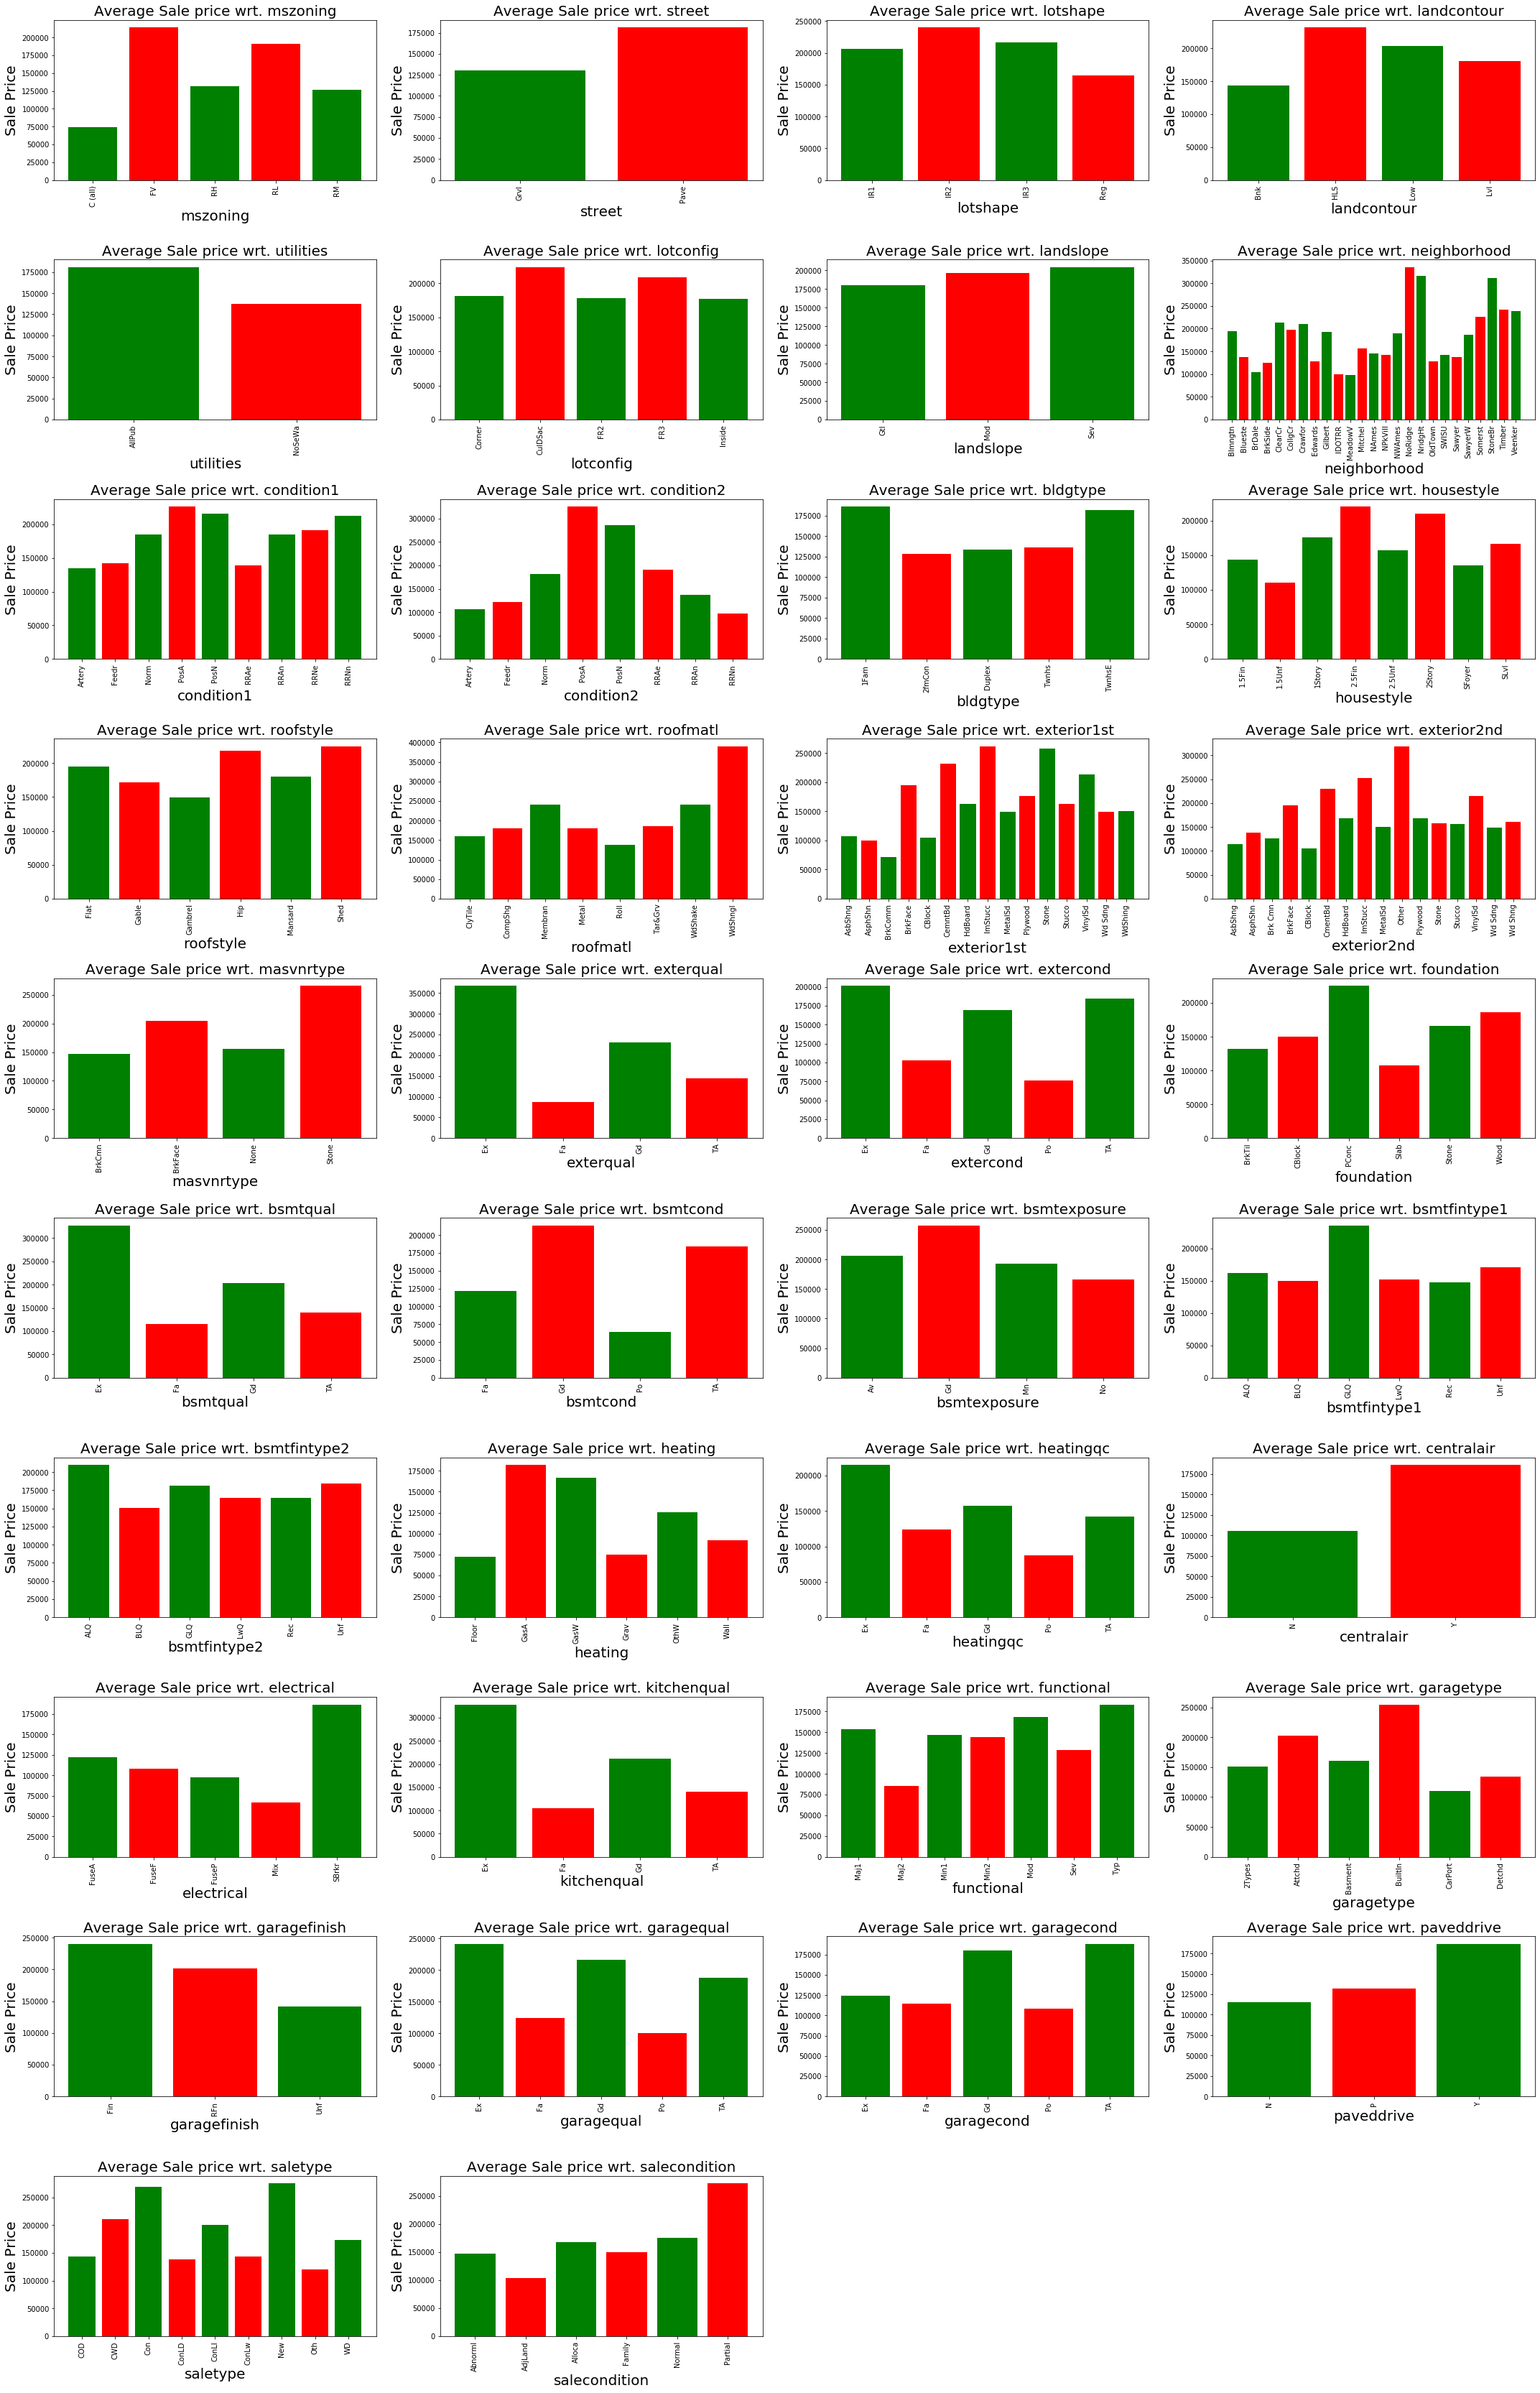

In [41]:
plt.figure(figsize = (30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11, 4, index+1)
    plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index, houseprices_df.groupby(column)['saleprice'].mean(),
           color = ('green', 'red'))
    plt.title("Average Sale price wrt. {}".format(column), fontsize = 20)
    plt.ylabel("Sale Price", fontsize = 20)
    plt.xlabel(column, fontsize = 20)
    plt.xticks(rotation = "vertical")
plt.tight_layout()

In [42]:
High_corr2 = pd.concat([High_corr2, pd.get_dummies(houseprices_df.street, prefix = 'street', drop_first = True)],
                      axis =1)
High_corr2 = pd.concat([High_corr2, pd.get_dummies(houseprices_df.mszoning, prefix = 'mszoning', drop_first = True)],
                      axis = 1)
High_corr2 = pd.concat([High_corr2, pd.get_dummies(houseprices_df.exterqual, prefix = 'exterqual', drop_first =True)],
                      axis =1)
dummy_columns = list(pd.get_dummies(houseprices_df.street, prefix = 'street', drop_first = True).columns)
dummy_columns = dummy_columns+list(pd.get_dummies(houseprices_df.mszoning, prefix = 'mszoning', drop_first = True).columns)
dummy_columns = dummy_columns+list(pd.get_dummies(houseprices_df.exterqual, prefix='exterqual', drop_first = True).columns)

In [43]:
High_corr2.head()

,overallqual,grlivarea,garagecars,log_totalsf,log_saleprice,street_Pave,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,exterqual_Fa,exterqual_Gd,exterqual_TA
0,7,1710,2,7.850104,12.247694,1,0,0,1,0,0,1,0
1,6,1262,2,7.833600,12.109011,1,0,0,1,0,0,0,1
2,7,1786,2,7.903227,12.317167,1,0,0,1,0,0,1,0
3,7,1717,3,7.813187,11.849398,1,0,0,1,0,0,0,1
4,8,2198,3,8.114624,12.429216,1,0,0,1,0,0,1,0


In [44]:
X = High_corr2.drop('log_saleprice', axis =1)
Y = High_corr2['log_saleprice']

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 456)
print("The number of observations in training set is {}".format(len(X_train)))
print("The number of observations in test set is {}".format(len(X_test)))

The number of observations in training set is 1168
The number of observations in test set is 292


In [46]:
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     490.0
Date:                Fri, 03 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:38:25   Log-Likelihood:                 467.43
No. Observations:                1168   AIC:                            -908.9
Df Residuals:                    1155   BIC:                            -843.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.5712      0.245     30.922   

/Users/krishnadevabhaktuni/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Mean absolute error of the prediction is: 0.1060653744212826
Mean Squared error of the prediction is: 0.019993106417868247
Root Mean Squared Error of the prediction is 0.14139698164341502
Mean absolute percentage error of the prediction is: 0.8885817702439427


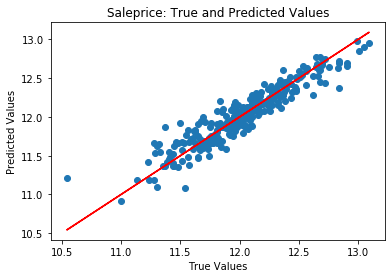

In [47]:
from sklearn.metrics import mean_absolute_error
X_test = sm.add_constant(X_test)
Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color = 'red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Saleprice: True and Predicted Values")

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean Squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root Mean Squared Error of the prediction is {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test-Y_preds)/Y_test))*100))

In [48]:
lrm = LinearRegression()
lrm.fit(X_train, Y_train)

Y_preds_train = lrm.predict(X_train)
Y_preds_test = lrm.predict(X_test)

print("R squared of the model is: {}".format(lrm.score(X_train, Y_train)))
print("R squared of the test is: {}".format(lrm.score(X_test, Y_test)))

R squared of the model is: 0.8358084637712553
R squared of the test is: 0.8722743878376858


### Our test set is performing better than our training set. Changing the test variable to 30% and performing the test again for better results

In [49]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.3, random_state = 456)
print("The number of observations in training set is {}".format(len(X_train1)))
print("The number of observations in test set is {}".format(len(X_test1)))

The number of observations in training set is 1022
The number of observations in test set is 438


In [50]:
X_train1 = sm.add_constant(X_train1)
results = sm.OLS(Y_train1, X_train1).fit()
print(results.summary())

/Users/krishnadevabhaktuni/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     466.6
Date:                Fri, 03 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:38:26   Log-Likelihood:                 449.88
No. Observations:                1022   AIC:                            -873.8
Df Residuals:                    1009   BIC:                            -809.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.5948      0.253     29.978   

In [51]:
X_test1 = sm.add_constant(X_test1)

In [52]:
#Performing the model with 70% training and 30% test data
lrm = LinearRegression()
lrm.fit(X_train1, Y_train1)

Y_preds_train1 = lrm.predict(X_train1)
Y_preds_test1 = lrm.predict(X_test1)

print("R squared of the model is: {}".format(lrm.score(X_train1, Y_train1)))
print("R squared of the test is: {}".format(lrm.score(X_test1, Y_test1)))

R squared of the model is: 0.8473236898122193
R squared of the test is: 0.8284901300472965


### We can see that the R-squared value came down to 82.8 from 87 and is close to training performance after increasing the test data to 30%

### Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

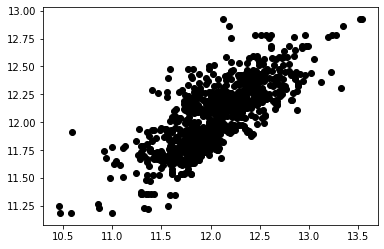

In [53]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = X_train1
Y = Y_train1
knn.fit(X, Y)
Y_ = knn.predict(X_test1)
y_pred_train = knn.predict(X_train1)
plt.scatter(Y, y_pred_train, c = 'k', label ='data')

In [54]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors= 10, weights='distance')
X = X_train1
Y = Y_train1
knn_w.fit(X, Y)
Y_ = knn.predict(X_test1)


In [55]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.50 (+/- 0.07)
Weighted Accuracy: 0.53 (+/- 0.06)


It appears that OLS is a better method than KNN for this dataset, tried using different values n_neighbours but it does not make much difference in accuracy. Using the same features f

In [59]:
print("R-squared value of the training set is {}".format(knn.score(X, Y, sample_weight=None)))
print("R-squared value of the test is {}".format(knn.score(X_test1, Y_test1)))

R-squared value of the training set is 0.5880798905251339
R-squared value of the test is 0.5337969788247701


We got an R-Squared value of 0.58 for training data and 0.53 for testing data